In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import alex_cifar10

branchyNet = alex_cifar10.get_network()
branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import mnist, pcifar10
x_train, y_train, x_test, y_test = pcifar10.get_data()

Settings

In [5]:
TRAIN_BATCHSIZE = 512
TEST_BATCHSIZE = 128
TRAIN_NUM_EPOCHS = 50

Train Main Network

In [ ]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

Train BranchyNet

In [ ]:
TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                                   num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

In [ ]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

In [ ]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Get exit result, compute openmax vs softmax

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import dill
with open("_models/alexnet_cifar10.bn", "rb") as f:
    branchyNet = dill.load(f)

In [3]:
from datasets import mnist, pcifar10
x_train, y_train, x_test, y_test = pcifar10.get_data()

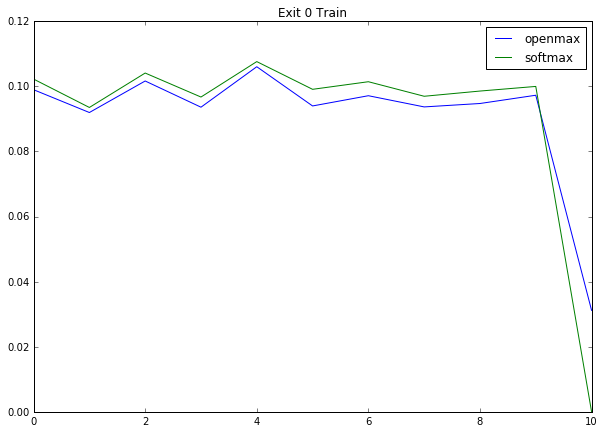

[ 0.09895241  0.09194593  0.10163216  0.09358114  0.10601289  0.09396208
  0.0971063   0.09366669  0.09471672  0.09725295  0.03117074]
[ 0.10221956  0.09349772  0.10407394  0.09670094  0.10759072  0.09907273
  0.10140614  0.09693923  0.09854002  0.09995899  0.        ]


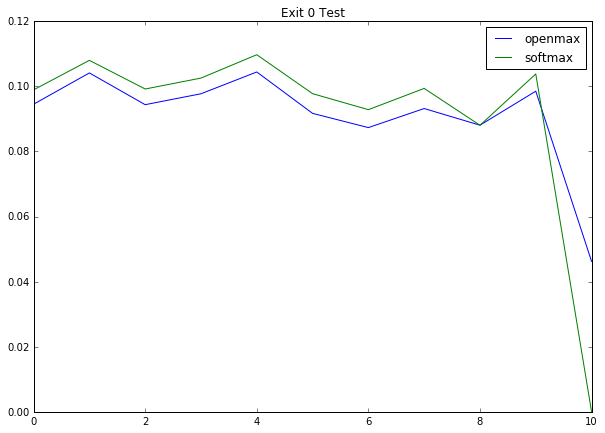

[ 0.0944952   0.10410703  0.0943544   0.0977067   0.10440284  0.09168421
  0.0873125   0.09317078  0.08804896  0.09850255  0.04621483]
[ 0.09890112  0.10797508  0.09917223  0.10252252  0.10970305  0.09773609
  0.09282003  0.09935406  0.08803098  0.10378484  0.        ]


In [88]:
import scipy as sp

branchyNet.testing()
branchyNet.to_cpu()

from openmax.openmax import OpenMax, get_openmax_scores, plot_openmax_mean, expand_dims

size = 5000

for i, model in enumerate(branchyNet.models[:1]):
    features_train = expand_dims(model.test(x_train[:size]).data)
    features_test = expand_dims(model.test(x_test[:size]).data)
    
    openmax = OpenMax(tailsize=40, distance_type="eucos", alpharank=1)
    openmax.fit(features_train,y_train[:size])

    openmax_vs_train, softmax_vs_train = get_openmax_scores(features_train, openmax)
    openmax_vs_test, softmax_vs_test = get_openmax_scores(features_test, openmax)
    
    plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit {} Train'.format(i))
    plot_openmax_mean(openmax_vs_test, softmax_vs_test, title='Exit {} Test'.format(i))


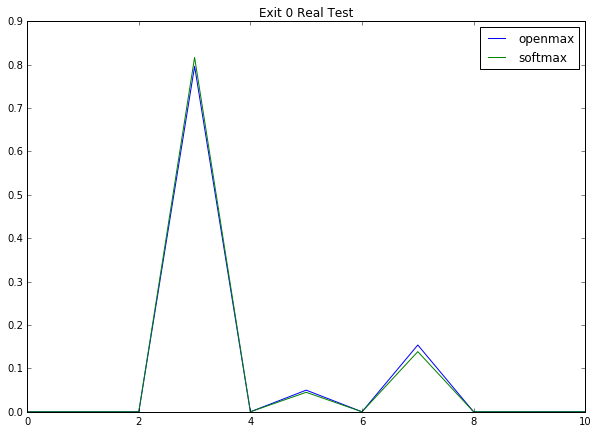

[  1.57069785e-12   8.22417843e-18   3.25483456e-06   7.96102766e-01
   2.77348480e-08   4.98914903e-02   1.00169393e-07   1.53912821e-01
   1.89485599e-18   2.15809014e-15   8.95394911e-05]
[  1.41441730e-12   7.40587872e-18   2.93098719e-06   8.16470623e-01
   2.49752983e-08   4.49274108e-02   9.02028745e-08   1.38598874e-01
   1.70632254e-18   1.94336167e-15   0.00000000e+00]


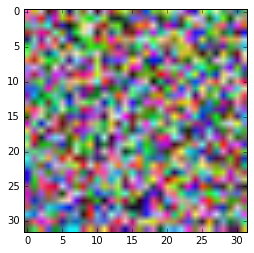

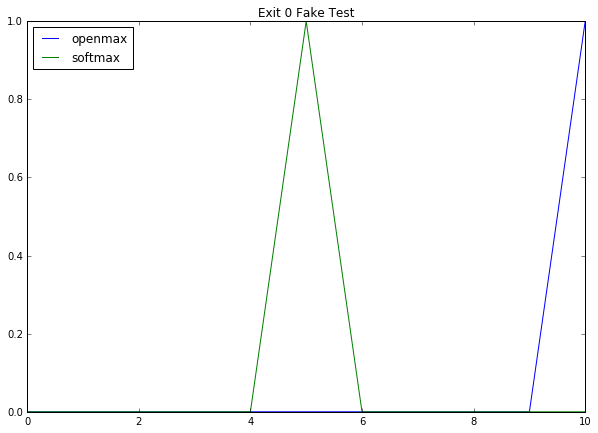

[  1.52971988e-57   3.00294294e-85   3.93702301e-55   3.94431780e-08
   4.36941348e-33   1.64114988e-27   1.85265514e-66   7.34360318e-32
   3.14159325e-44   4.21343679e-74   9.99999961e-01]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.94431794e-08
   4.36940544e-33   1.00000000e+00   0.00000000e+00   7.34358240e-32
   3.08285662e-44   0.00000000e+00   0.00000000e+00]


In [113]:
i=2003
x_real = x_test[i:i+1]

features_test = sp.expand_dims(model.test(x_real.astype(np.float32)).data,1)
openmax_vs_train, softmax_vs_train = get_openmax_scores(features_test, openmax)

plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit 0 Real Test')

x_fake = np.random.random((1,3,32,32))*10-1.5

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_fake[0].transpose(1,2,0))

features_test = sp.expand_dims(model.test(x_fake.astype(np.float32)).data,1)
openmax_vs_train, softmax_vs_train = get_openmax_scores(features_test, openmax)

plot_openmax_mean(openmax_vs_train, softmax_vs_train, title='Exit 0 Fake Test')
